<a href="https://colab.research.google.com/github/Dav1dRoq/Visual-Mapping-for-Collision-Avoidance-and-Navigation/blob/main/413_Final_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
%%writefile yolo_nav.py

import argparse
from pathlib import Path

import cv2
from ultralytics import YOLO


# -----------------------------
# Model loading
# -----------------------------
YOLO_MODEL_PATH = "yolov8n.pt"  # small + fast
yolo_model = YOLO(YOLO_MODEL_PATH)


# -----------------------------
# Obstacle detection & logic
# -----------------------------
def detect_obstacles(frame, conf_threshold=0.3):
    height, width, _ = frame.shape
    regions = {"left": [], "center": [], "right": []}
    results = yolo_model(frame)[0]

    for box in results.boxes:
        conf = float(box.conf.item())
        if conf < conf_threshold:
            continue

        cls_id = int(box.cls.item())
        label = results.names[cls_id]

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cx = (x1 + x2) // 2

        if cx < width / 3:
            regions["left"].append(label)
        elif cx < 2 * width / 3:
            regions["center"].append(label)
        else:
            regions["right"].append(label)

    return regions, results


def determine_direction(regions):
    left_blocked = bool(regions["left"])
    center_blocked = bool(regions["center"])
    right_blocked = bool(regions["right"])

    obstacle_label = (
        regions["center"][0]
        if regions["center"]
        else regions["left"][0]
        if regions["left"]
        else regions["right"][0]
        if regions["right"]
        else None
    )

    if center_blocked:
        if left_blocked and not right_blocked:
            return "Go right", obstacle_label
        elif right_blocked and not left_blocked:
            return "Go left", obstacle_label
        elif left_blocked and right_blocked:
            return "Stop", obstacle_label
        else:
            return "Go left", obstacle_label
    else:
        if left_blocked and not right_blocked:
            return "Go right", regions["left"][0]
        elif right_blocked and not left_blocked:
            return "Go left", regions["right"][0]
        else:
            return "Go straight", obstacle_label


def frame_to_command(frame, debug=False):
    regions, results = detect_obstacles(frame)
    if debug:
        print("[DETECTIONS]", regions)

    direction, obstacle = determine_direction(regions)

    if obstacle:
        command = f"{direction} ({obstacle})"
    else:
        command = direction

    return command, results


# -----------------------------
# Drawing utilities
# -----------------------------
def draw_results(frame, results, command):
    annotated = frame.copy()

    # Draw YOLO boxes
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls_id = int(box.cls.item())
        label = results.names[cls_id]
        conf = float(box.conf.item())

        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            annotated,
            f"{label} {conf:.2f}",
            (x1, max(y1 - 5, 15)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
            cv2.LINE_AA,
        )

    # Draw command
    cv2.putText(
        annotated,
        command,
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0, 255, 255),
        3,
        cv2.LINE_AA,
    )

    return annotated


# -----------------------------
# IMAGE Mode
# -----------------------------
def process_image(image_path, show=False, output_path="annotated_output.png"):
    # Note: We added an 'output_path' argument to save the file
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not load image {image_path}")
        return output_path

    command, results = frame_to_command(frame, debug=True)

    print("\n=== IMAGE RESULT ===")
    print("File:", image_path)
    print("Command:", command)

    annotated = draw_results(frame, results, command)

    # --- NEW CODE TO SAVE THE IMAGE ---
    cv2.imwrite(output_path, annotated)
    print(f"Annotated image saved to: {output_path}")

    # The 'if show:' block is now removed or left with minimal logic for Colab
    return output_path


# -----------------------------
# VIDEO Mode
# -----------------------------
def process_video(video_path, out_path=None, every_sec=1.0, show=False, debug=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    frame_interval = max(1, int(fps * every_sec))

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    writer = None
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

    print(f"\n=== VIDEO MODE ===")
    print(f"File: {video_path}")
    print(f"FPS: {fps:.2f}")
    print(f"Command update every {every_sec:.2f} sec")

    frame_idx = 0
    last_command = "Go straight"
    last_results = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_interval == 0:
            last_command, last_results = frame_to_command(frame, debug=debug)
            if debug:
                print(f"Frame {frame_idx}: {last_command}")

        annotated = draw_results(frame, last_results, last_command)

        if show:
            cv2.imshow("YOLO Video Navigation", annotated)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

        if writer:
            writer.write(annotated)

        frame_idx += 1

    cap.release()
    if writer:
        writer.release()

    if show:
        cv2.destroyAllWindows()


# -----------------------------
# CLI
# -----------------------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--image", type=str, help="Path to a single image")
    parser.add_argument("--video", type=str, help="Path to a video file")
    # We will use the --out argument to save the image as well as the video
    parser.add_argument("--out", type=str, help="Where to save annotated output (image or video)")
    parser.add_argument("--every_sec", type=float, default=1.0, help="Update rate for video")
    parser.add_argument("--show", action="store_true", help="Show window output")
    parser.add_argument("--debug", action="store_true", help="Print detections/commands")

    args = parser.parse_args()

    output_file = args.out if args.out else "default_output.png"

    if args.image:
        process_image(args.image, output_path=output_file)

    elif args.video:
        # (Video processing logic remains the same)
        process_video(
            args.video,
            out_path=args.out,
            every_sec=args.every_sec,
            show=args.show,
            debug=args.debug,
        )

    else:
        print("Please provide either --image or --video")

if __name__ == "__main__":
    main()

Writing yolo_nav.py


In [ ]:
# Set every_sec lower for faster command updates in the video
!python yolo_nav.py --video "hallway1.mp4" --out "annotated_output.mp4" --every_sec 0.5 --debug


=== VIDEO MODE ===
File: hallway1.mp4
FPS: 59.94
Command update every 0.50 sec

0: 384x640 (no detections), 281.4ms
Speed: 10.0ms preprocess, 281.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
[DETECTIONS] {'left': [], 'center': [], 'right': []}
Frame 0: Go straight

0: 384x640 (no detections), 205.8ms
Speed: 2.6ms preprocess, 205.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
[DETECTIONS] {'left': [], 'center': [], 'right': []}
Frame 29: Go straight

0: 384x640 (no detections), 159.6ms
Speed: 2.8ms preprocess, 159.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
[DETECTIONS] {'left': [], 'center': [], 'right': []}
Frame 58: Go straight

0: 384x640 (no detections), 147.3ms
Speed: 2.6ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
[DETECTIONS] {'left': [], 'center': [], 'right': []}
Frame 87: Go straight

0: 384x640 (no detections), 146.7ms
Speed: 2.7ms preprocess, 146.7ms inference,

In [ ]:
!python yolo_nav.py --image "BlockedHallway2.webp" --out "annotated_hallway9.png" --debug


0: 640x480 5 suitcases, 259.8ms
Speed: 14.8ms preprocess, 259.8ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 480)
[DETECTIONS] {'left': ['suitcase', 'suitcase'], 'center': [], 'right': []}

=== IMAGE RESULT ===
File: BlockedHallway2.webp
Command: Go right (suitcase)
Annotated image saved to: annotated_hallway9.png


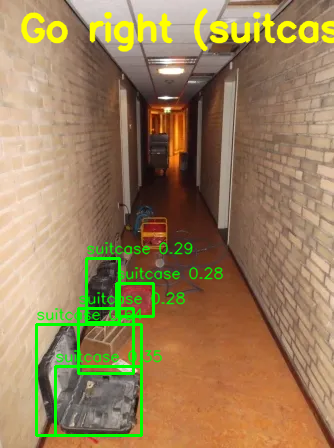

In [ ]:
from IPython.display import Image
Image(filename='annotated_hallway9.png')

In [ ]:
# To download the output file
from google.colab import files
files.download("annotated_output.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>